# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-random'
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctor-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(random_indices)
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            '1-FR': [y_train[i][0] for i in temp],
            '2-GI': [y_train[i][1] for i in temp],
            '3-PI': [y_train[i][2] for i in temp],
            '4-DM': [y_train[i][3] for i in temp],
            '5-EDTRB': [y_train[i][4] for i in temp],
            '6-RE': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6055, Accuracy: 0.8285, F1 Micro: 0.8825, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3994, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2438, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2239, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2275

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4931, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2201, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1893, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1604, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1144,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1841, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1719, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1123, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0982,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1418, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1027,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2039, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.7241
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9551, F1 Micro: 0.9656, F1 Macro: 0.7315
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0528, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.736
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.785
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2968, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1605, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1544, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7225
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9535, F1 Micro: 0.9649, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7261
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7267
Epoch 10/10, Train Loss: 0.0349, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2801, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.727
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7249
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0305, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2834, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1472, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7344
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6983
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7254
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7834
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7241
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7183
Iteration 250: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7192
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9503, F1 Micro: 0.9627, F1 Macro: 0.7023
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.7078
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9535, F1 Micro: 0.9651, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2825, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7156
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7798
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9567, F1 Micro: 0.9674, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2743, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1708, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7116
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.785
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.156, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7225
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9519, F1 Micro: 0.9638, F1 Macro: 0.7221
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9503, F1 Micro: 0.9621, F1 Macro: 0.709
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9503, F1 Micro: 0.9624, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7946
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7898
Iteration 300: Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.168, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7175
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7929
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9567, F1 Micro: 0.9675, F1 Macro: 0.8128
Epoch 10/10, Train Loss: 0.0321, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2693, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1435, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1313, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7167
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7131
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9519, F1 Micro: 0.9638, F1 Macro: 0.7107
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7231
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7723
Iteration 320: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.255, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1313, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.094, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0664, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7268
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7312
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7367
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.785
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2501, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7263
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2441, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1522, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.049, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9631, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1077, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7957
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7949
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2556, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1491, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1366, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.093, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.756
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0522, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7849
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8049
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2598, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0944, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7393
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7381
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7225
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7891
Epoch 10/10, Train Loss: 0.0222, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2407, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1756, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1511, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.0949, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7955
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1596, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1246, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.0908, Accuracy: 0.9503, F1 Micro: 0.962, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7174
Epoch 7/10, Train Loss: 0.0526, Accuracy: 0.9535, F1 Micro: 0.9644, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8035
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0

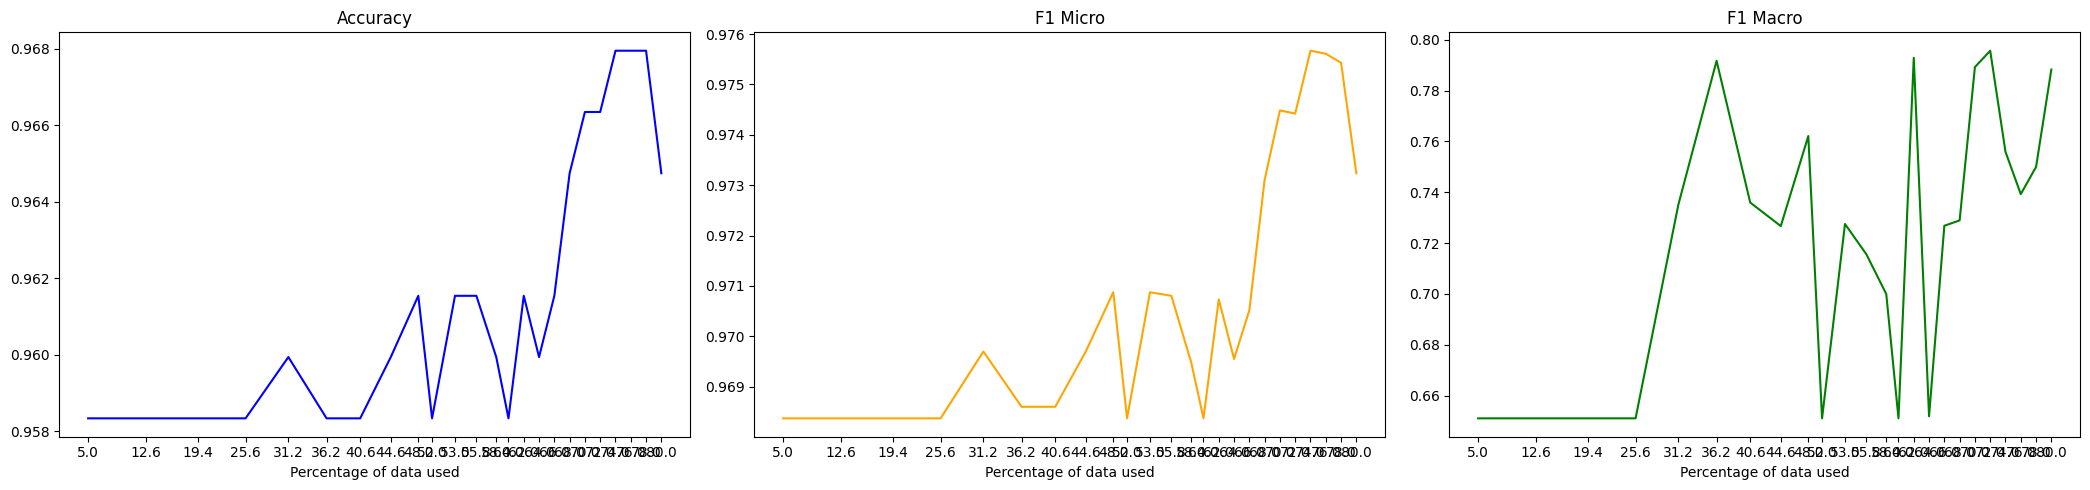

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6122, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.141, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2228, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1158,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.115, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3642, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3277, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1329, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6501
Epoch 10/10, Train Loss: 0.0497, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3228, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2985, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1632, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1202, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1612, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2849, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1401, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1434, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1483, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.142, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1594, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7651
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.278, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1367, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1376, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0699, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9647, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2633, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1499, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7626
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7001
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1763, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1379, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1242, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0989, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7362
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8198
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.0851, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7928
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8626
Epoch 10/10, Train Loss: 0.0201, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2578, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1544, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8043
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8301
Epoch 10/10, Train Loss: 0.0272, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6947
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0783, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 9/10, Train Loss: 0.0263, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0265, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2555, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1593, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1149, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.0809, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7066
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0464, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1339, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0707, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7477
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8134
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7459
Epoch 10/10, Train Loss: 0.0276, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2346, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1535, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 4/10, Train Loss: 0.1192, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7015
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0609, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7865
Epoch 9/10, Train Loss: 0.0215, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7874
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7852
Iteration 370: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2356, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1265, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0947, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7936
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.0383, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8317
Epoch 10/10, Train Loss: 0.0229, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2531, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1727, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1048, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0782, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0628, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.036, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9631, F1 Micro: 0.971

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2381, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1443, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1458, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0863, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Epoch 8/10, Train Loss: 0.0312, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8116
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7942
Epoch 10/

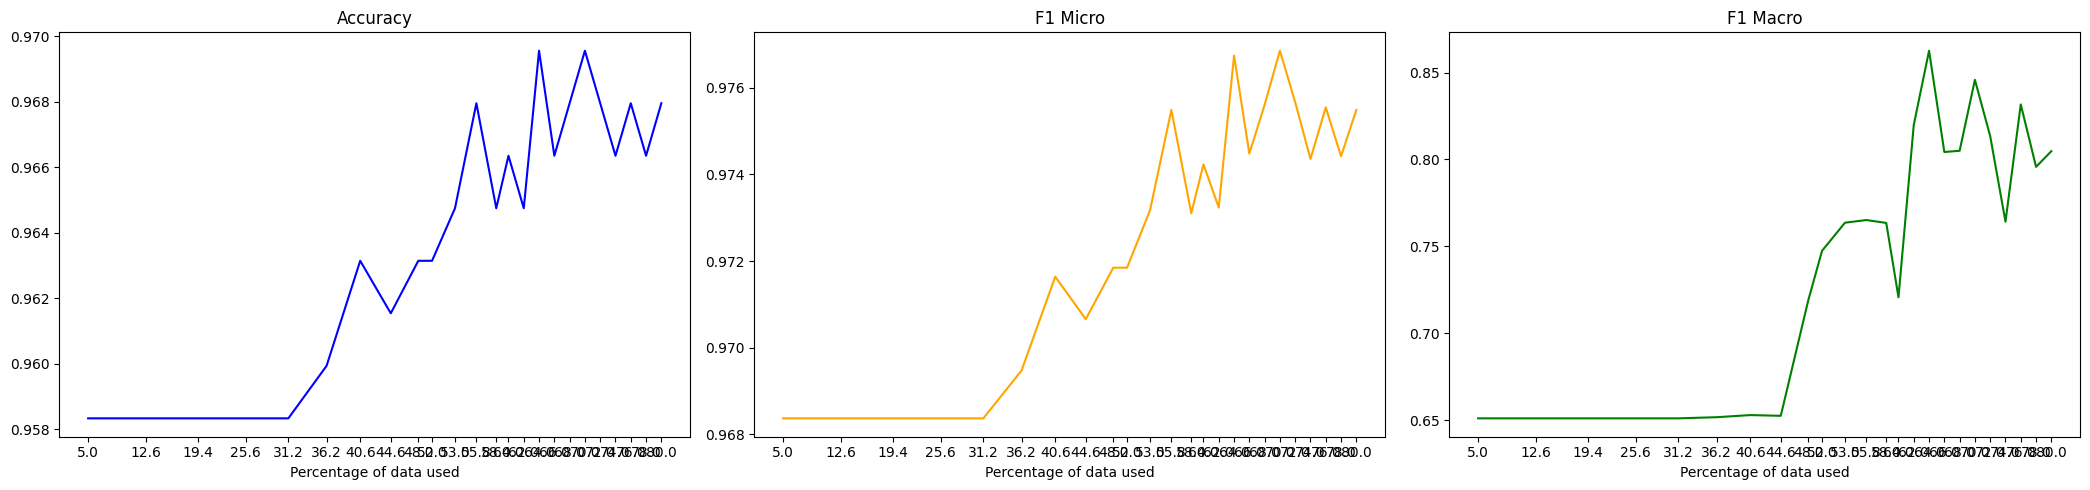

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3077, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2331, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1252, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9519, F1 Micro: 0.9638, F1 Macro: 0.6844
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1475, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9599, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1388, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9583, F1 Micro: 0.9675, F1 Macro: 0.6491
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 10/10, Train Loss: 0.0637, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2986, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2925, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1249, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6522
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2727, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1586, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1465, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.108, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6557
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2694, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1393, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6905
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6958
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1367, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 10/10, Train Loss: 0.0404, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1329, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7086
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2514, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0749, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9663, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.741
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9679, F1 Micro: 0.9756

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.248, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7184
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7875
Epoch 10/10, Train Loss: 0.0278, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1492, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Epoch 10/10, Train Loss: 0.0248, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2532, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1411, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0743, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7868
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0313, Accuracy: 0.9679, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1457, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 6/10, Train Loss: 0.0732, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2372, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1639, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.0905, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7701
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2407, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.125, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0347

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2285, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9535, F1 Micro: 0.9651, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2406, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1598, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1462, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.0696, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7182
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0162, Accuracy: 

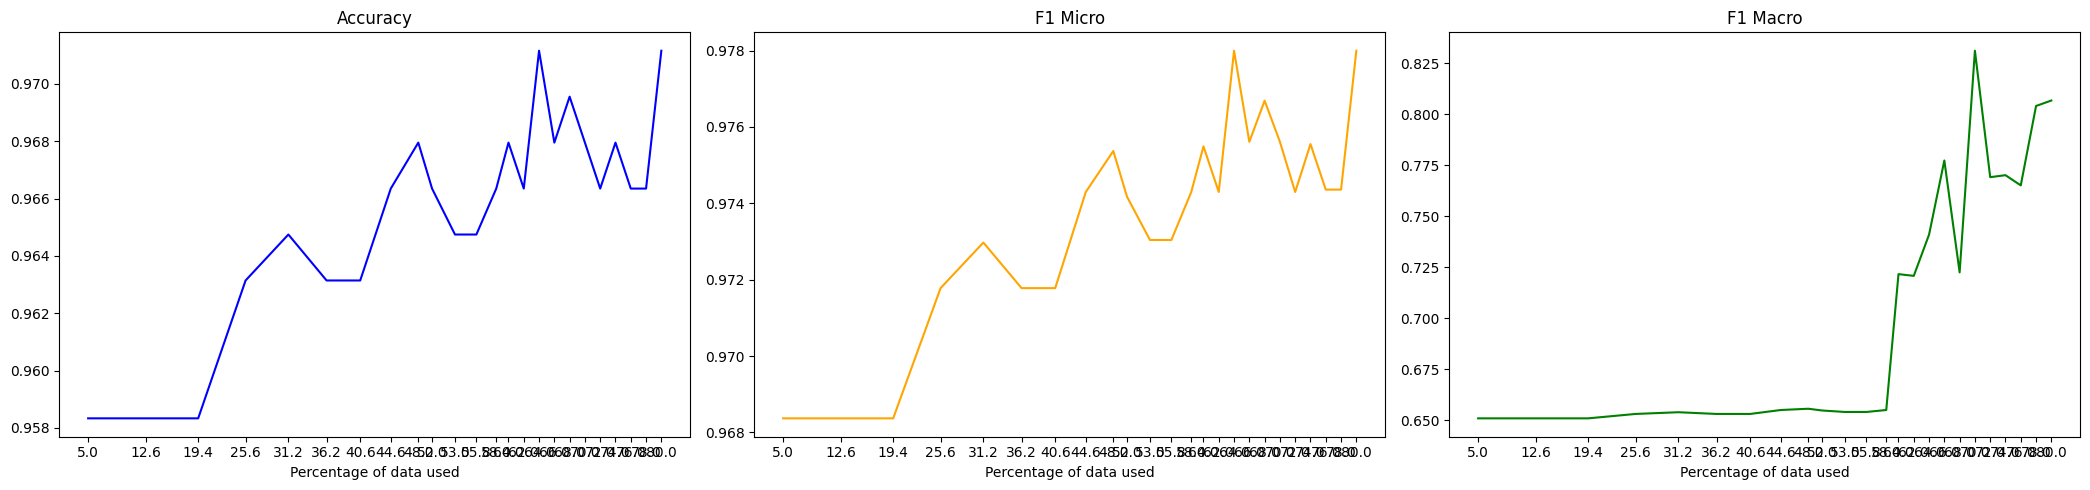

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3222, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2236, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2109, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1944, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1271, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1644, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4167, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1115,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1895, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9599, F1 Micro: 0.9695, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1301, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1934, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9455, F1 Micro: 0.959, F1 Macro: 0.651
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3107, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1998, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1564, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9551, F1 Micro: 0.9658, F1 Macro: 0.6489
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.316, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2066, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9519, F1 Micro: 0.9635, F1 Macro: 0.6491
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9503, F1 Micro: 0.9618, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9455, F1 Micro: 0.9588, F1 Macro: 0.6898
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9519, F1 Micro: 0.9634, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3043, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1531, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9519, F1 Micro: 0.9636, F1 Macro: 0.6501
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9567, F1 Micro: 0.9668, F1 Macro: 0.6502
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9503, F1 Micro: 0.9621, F1 Macro: 0.6486
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9503, F1 Micro: 0.9621, F1 Macro: 0.6494
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.9519, F1 Micro: 0.9634, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1885, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7932
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9599, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2659, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1627, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9551, F1 Micro: 0.9658, F1 Macro: 0.7146
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2674, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9551, F1 Micro: 0.9658, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9615, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1635, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7514
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1681, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9599, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2518, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2319, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7187
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6988
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7515
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2436, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1599, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1541, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0271,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2414, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1354, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1491, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7623
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7421
Epoch 10/10, Train Loss: 0.022, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2347, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7628
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1682, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1287, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0582, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0429, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2283, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1339, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1174, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1006, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8192
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0372, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8196
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7515
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2383, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1424, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8293
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.8277
Epoch 8/10, Train Loss: 0.04, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7522
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8283
Epoch 10/10, Train Loss: 0.0176, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2239, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1659, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.83
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0234, Accuracy: 0.9696, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2213, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1459, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1341, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.0695, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0464, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7331
Epoch 8/10, Train Loss: 0.0308, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8017
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 10/10, Train Loss: 0.0182, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2225, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1514, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.094, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.0737, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0272, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8311
Epoch 10/10, Train Loss: 0.0173, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2283, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Epoch 5/10, Train Loss: 0.0865, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8321
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8134
Epoch 10/10, Train Loss: 0.0176, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macr

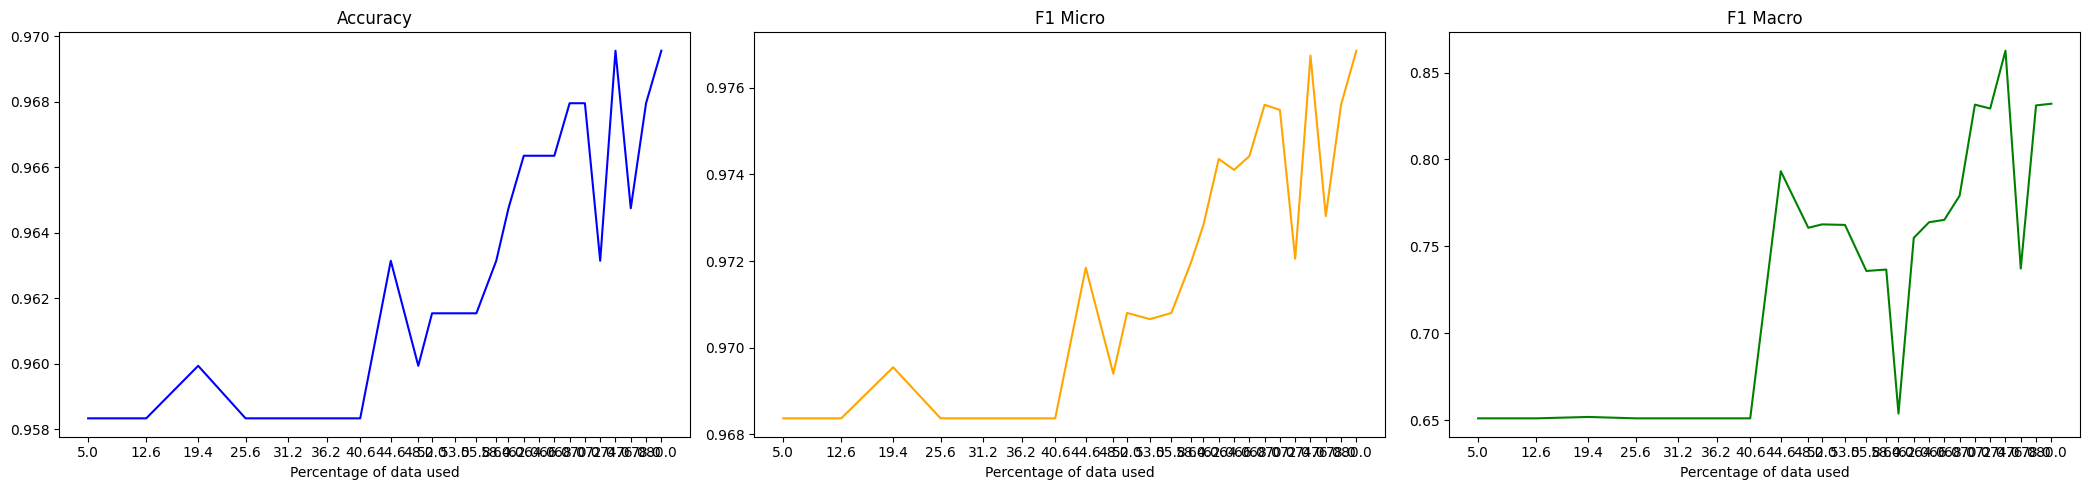

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1323, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1665, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4572, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1886, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1361, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1549, Accuracy: 0.9567, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3596, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1307, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 9/10, Train Loss: 0.1187, Accuracy: 0.9583, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3383, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1629, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1368, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1619, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1281, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2968, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9647, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2891, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1636, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7376
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7786
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1332, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9647, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9679, F1 Micro: 0.9752, F1 Macro: 0.7212
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7194
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1421, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6557
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1235, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7213
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9696, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2333, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2403, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.242, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1449, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9679, F1 Micro: 0.9751, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0258, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2479, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1468, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1293, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1018, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0265, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2416, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1489, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1368, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0383, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.02

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2438, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1398, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.09, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9696, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2319, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1568, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2319, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1286, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1267, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0939, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.051, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7361
Epoch 8/10, Train Loss: 0.0345, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7278
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.8035
Epoch 10/10, Train Loss: 0.0206, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2328, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1482, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.0841, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7469
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2264, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1407, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Epoch 6/10, Train Loss: 0.0677, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7901
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7966
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7235
Epoch 10/10, Train Loss: 0.018, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2392, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0841, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Epoch 6/10, Train Loss: 0.0568, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7278
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7821
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7875
Epoch 9/10, Train Loss: 0.0213, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2423, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1564, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1232, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7123
Epoch 5/10, Train Loss: 0.0829, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7262
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7375
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Epoch 10/10, Train Loss: 0.02, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8126
Iteration 390: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2314, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.0984, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7268
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.073, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7299
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.021, Accuracy: 

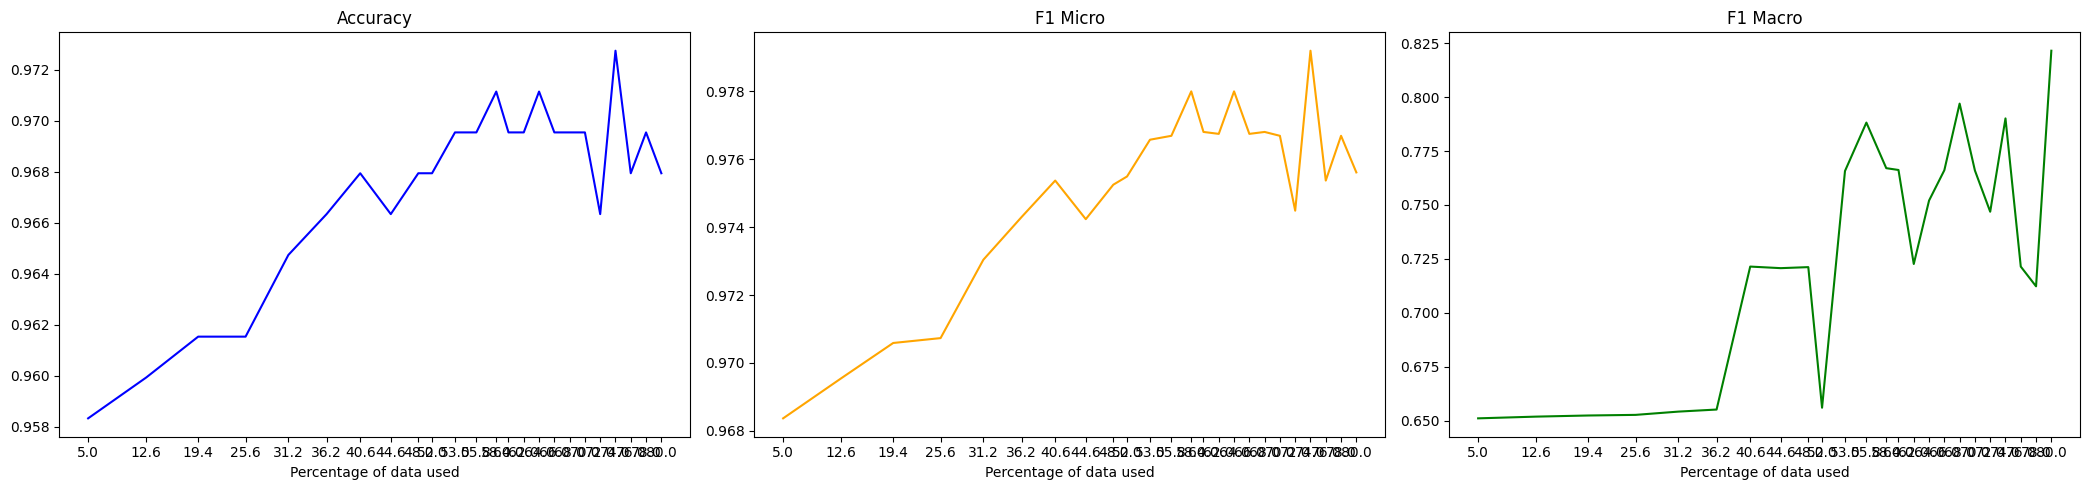

In [ ]:
active_learning(seeds[4], 4)